In [39]:
import pandas as pd
import numpy as np
from numpy import array

import confusion_matrix_pretty_print
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,classification_report,precision_score, roc_auc_score,\
auc, precision_recall_curve, roc_curve
from sklearn.model_selection import KFold
import sklearn

import snf
from snf import compute

from scipy.stats import sem, t
from scipy import mean

In [40]:
# data 
data = pd.read_csv('provider features and fraud labels.csv')
len(data[data['fraud_label']==1])

2167

In [41]:
2992-2167

825

In [42]:
data.columns

Index(['npi', 'fraud_label', 'nppes_provider_gender', 'provider_type',
       'line_srvc_cnt', 'bene_unique_cnt', 'bene_day_srvc_cnt',
       'average_Medicare_allowed_amt', 'average_submitted_chrg_amt',
       'average_Medicare_payment_amt', 'average_Medicare_standard_amt'],
      dtype='object')

In [43]:
def sim(x, data1, data0, similarity='cosine'):
    if similarity == 'cosine':
        data1 = data1.append(x)
        data0 = data0.append(x)
#         print(data1.shape,data0.shape)
        data1F = np.array(data1.values, dtype=np.float64)
        data0F = np.array(data0.values, dtype=np.float64)
        data1Sim = sklearn.metrics.pairwise.cosine_similarity(data1F, Y=None, dense_output=True)
        data0Sim = sklearn.metrics.pairwise.cosine_similarity(data0F, Y=None, dense_output=True)
        r1, c1 = data1Sim.shape
        r0, c0 = data0Sim.shape
#         print(data1Sim.shape, data0Sim.shape)
        if c1>5:
            scor1 = np.mean(np.sort(data1Sim[r1-1,:-1])[-5:-1])
        else:
            scor1 = np.mean(data1Sim[r1-1,:-1])
        if c0>5:
            scor0 = np.mean(np.sort(data0Sim[r0-1,:-1])[-5:-1])
        else:
            scor0 = np.mean(data0Sim[r0-1,:-1])

        return scor1/scor0

In [44]:
# np.sort(data1Sim[r1-1,:-1])[-5:-1]

/home/amin/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


300
              precision    recall  f1-score   support

           0       0.45      0.26      0.33        78
           1       0.77      0.89      0.83       222

    accuracy                           0.73       300
   macro avg       0.61      0.57      0.58       300
weighted avg       0.69      0.73      0.70       300



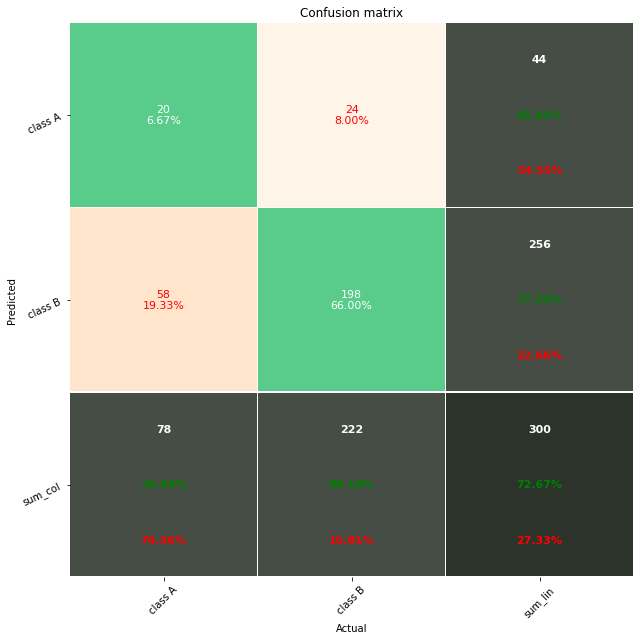

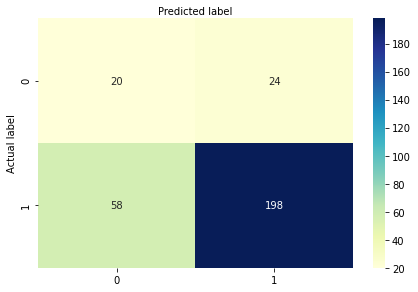

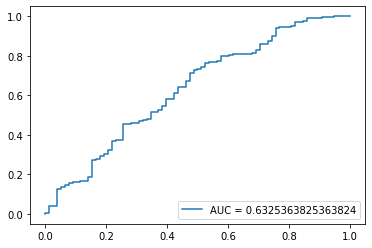

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


300
              precision    recall  f1-score   support

           0       0.62      0.34      0.44        93
           1       0.75      0.90      0.82       207

    accuracy                           0.73       300
   macro avg       0.68      0.62      0.63       300
weighted avg       0.71      0.73      0.70       300



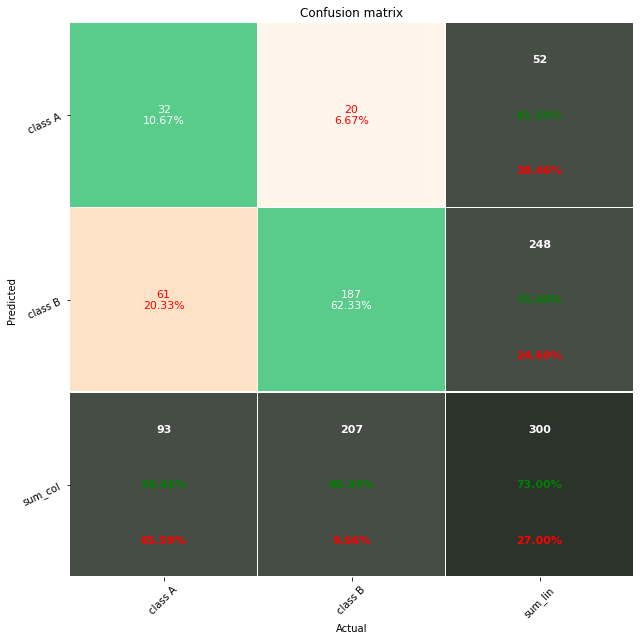

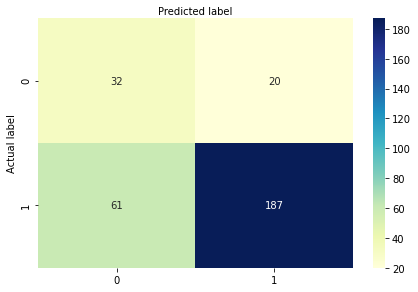

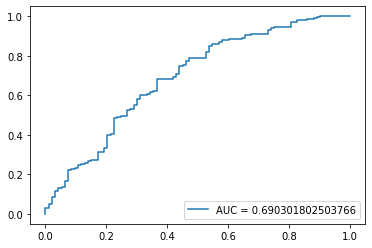

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


299
              precision    recall  f1-score   support

           0       0.49      0.27      0.34        79
           1       0.77      0.90      0.83       220

    accuracy                           0.73       299
   macro avg       0.63      0.58      0.59       299
weighted avg       0.70      0.73      0.70       299



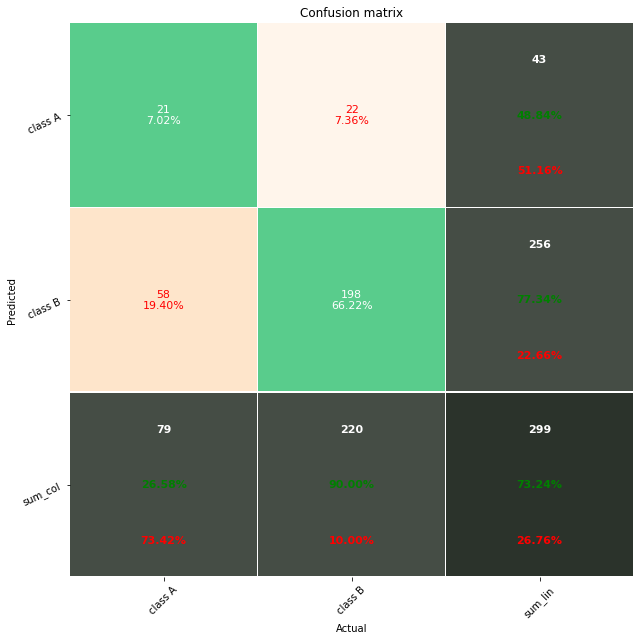

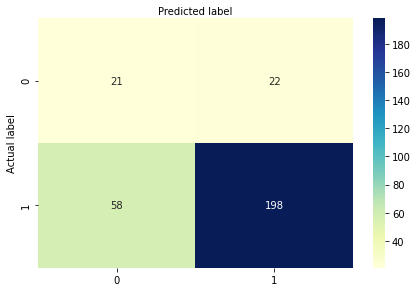

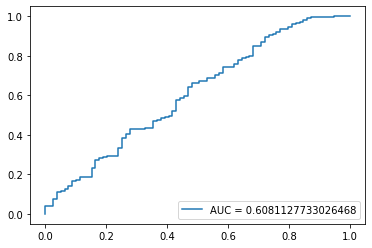

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


299
              precision    recall  f1-score   support

           0       0.48      0.28      0.36        74
           1       0.79      0.90      0.84       225

    accuracy                           0.75       299
   macro avg       0.63      0.59      0.60       299
weighted avg       0.71      0.75      0.72       299



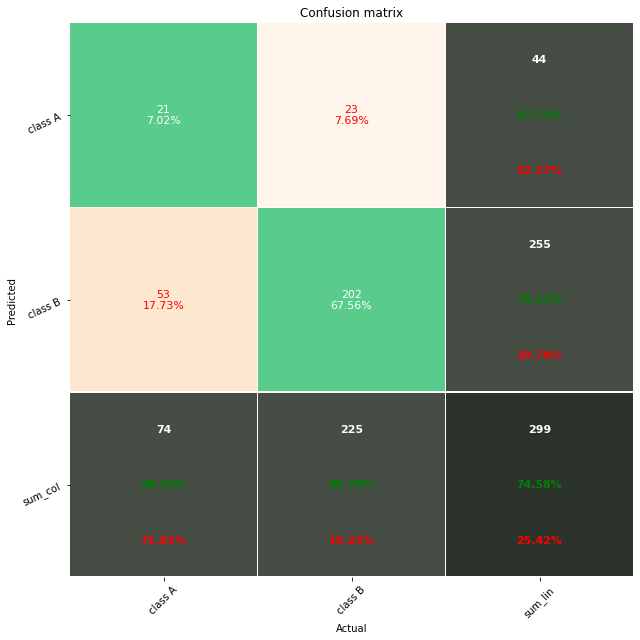

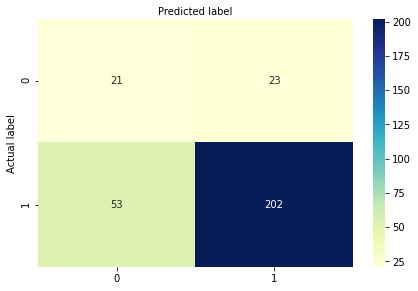

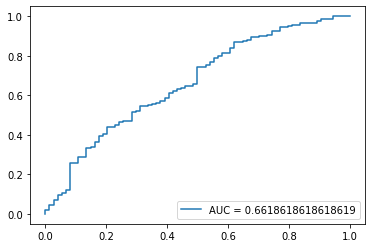

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


299
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        79
           1       0.79      0.93      0.85       220

    accuracy                           0.76       299
   macro avg       0.69      0.62      0.63       299
weighted avg       0.74      0.76      0.73       299



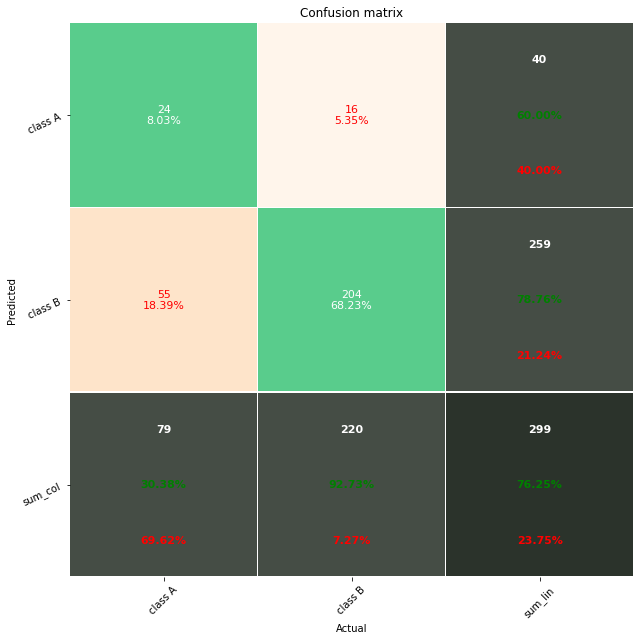

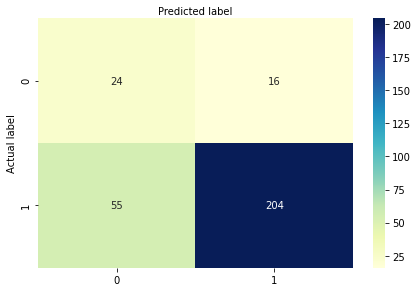

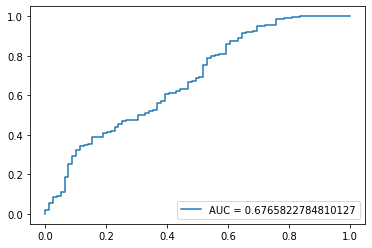

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


299
              precision    recall  f1-score   support

           0       0.60      0.33      0.42        85
           1       0.77      0.91      0.84       214

    accuracy                           0.75       299
   macro avg       0.68      0.62      0.63       299
weighted avg       0.72      0.75      0.72       299



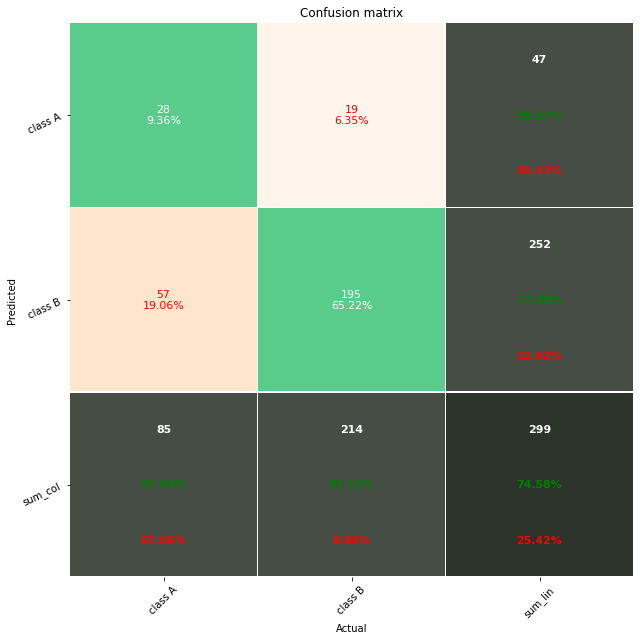

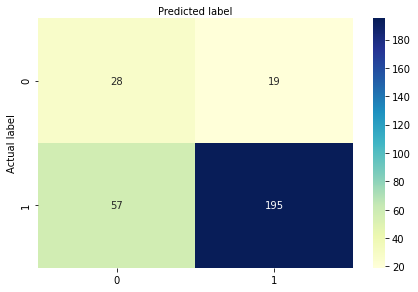

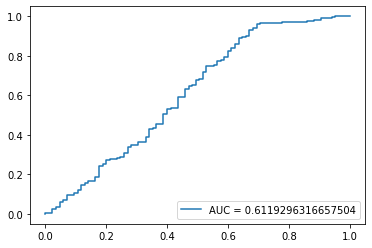

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


299
              precision    recall  f1-score   support

           0       0.53      0.29      0.38        85
           1       0.76      0.90      0.82       214

    accuracy                           0.73       299
   macro avg       0.65      0.60      0.60       299
weighted avg       0.70      0.73      0.70       299



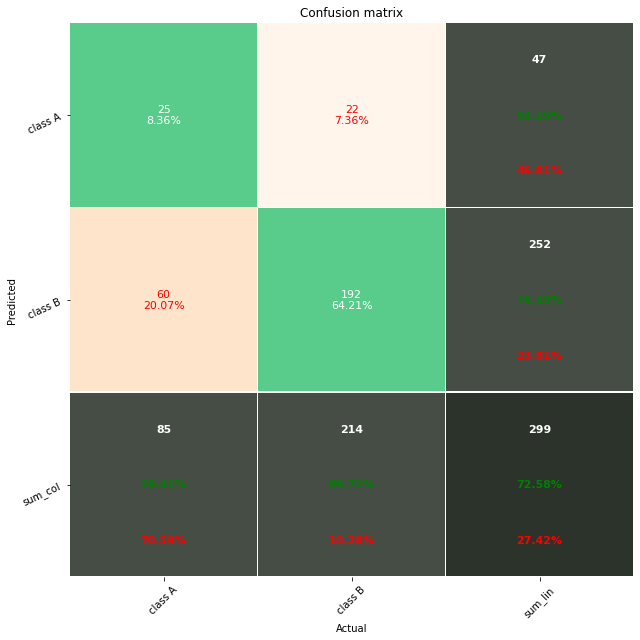

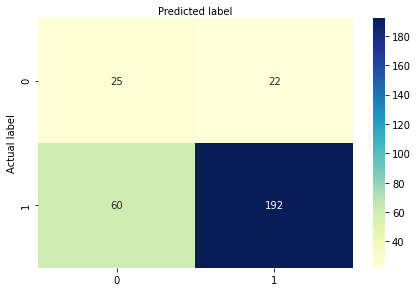

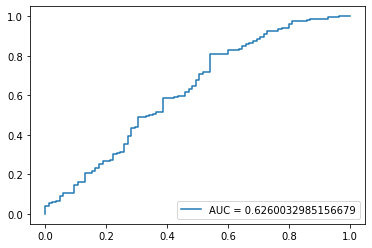

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


299
              precision    recall  f1-score   support

           0       0.62      0.28      0.38        87
           1       0.76      0.93      0.83       212

    accuracy                           0.74       299
   macro avg       0.69      0.60      0.61       299
weighted avg       0.72      0.74      0.70       299



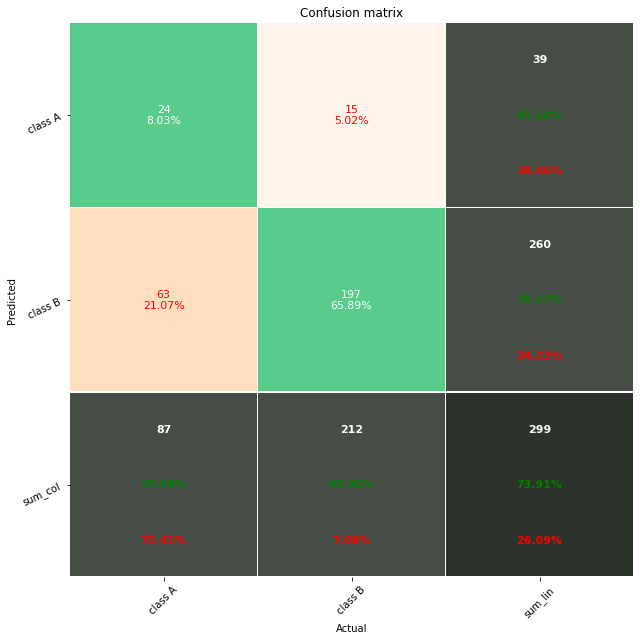

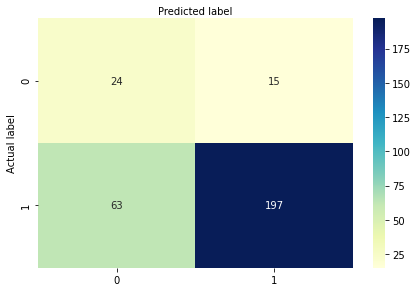

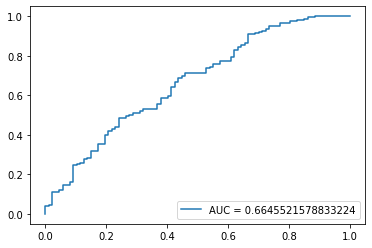

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


299
              precision    recall  f1-score   support

           0       0.50      0.27      0.35        86
           1       0.75      0.89      0.82       213

    accuracy                           0.71       299
   macro avg       0.63      0.58      0.58       299
weighted avg       0.68      0.71      0.68       299



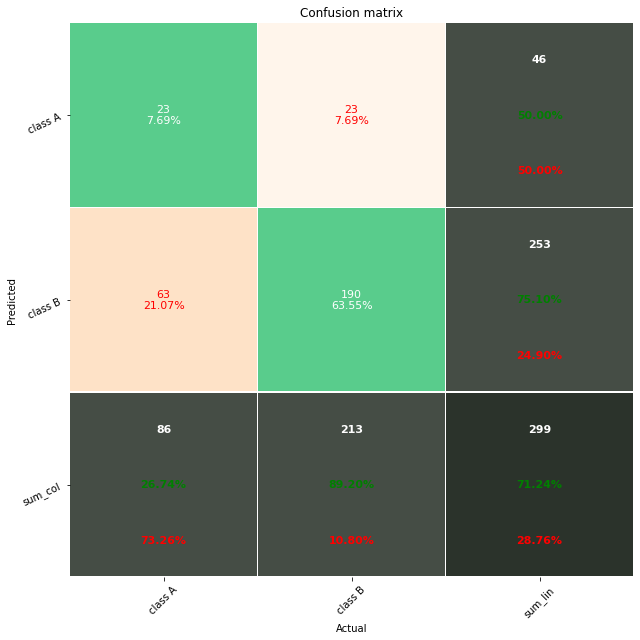

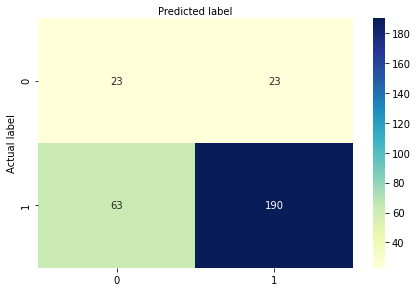

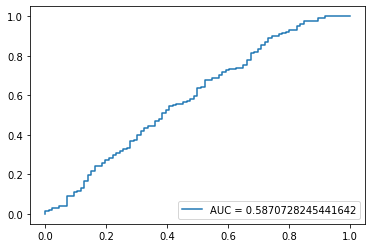

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


299
              precision    recall  f1-score   support

           0       0.56      0.23      0.32        79
           1       0.77      0.94      0.85       220

    accuracy                           0.75       299
   macro avg       0.67      0.58      0.59       299
weighted avg       0.72      0.75      0.71       299



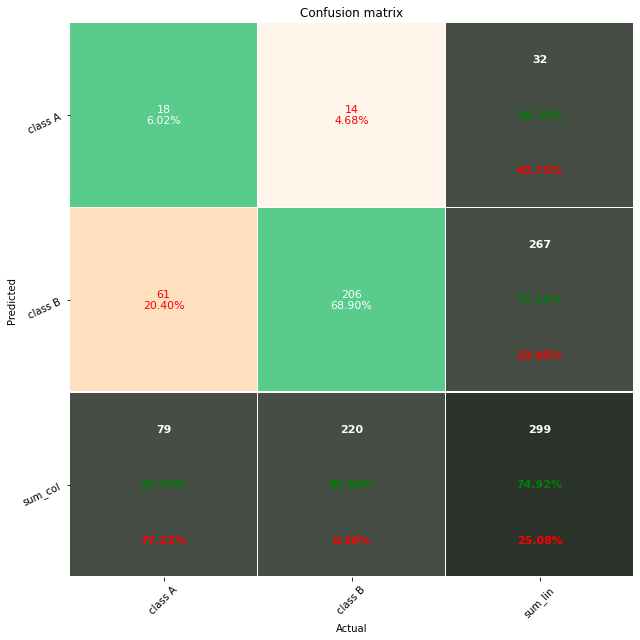

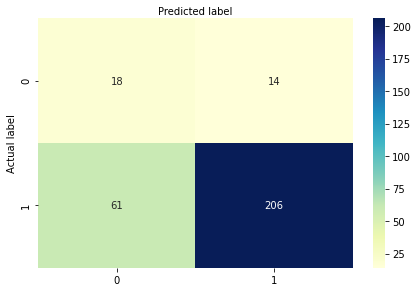

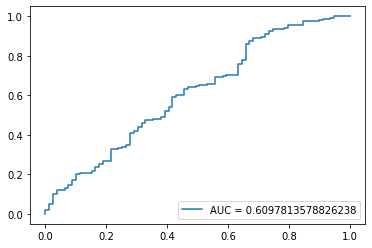

0.6368734369177199


In [46]:
# prepare cross validation
aucList = []
kfold = KFold(10, True, 1)
sensitivityList = specificityList = []
# enumerate splits
K_foldPredicts = []
for train, test in kfold.split(data['npi']):
    positiveData = data.iloc[train,2:][data['fraud_label']==1]
    negativeData = data.iloc[train,2:][data['fraud_label']==0]
    testLabel =  list(data.iloc[test,1])
    print(len(testLabel))
    testData =  data.iloc[test,2:]
#     print(negativeData.shape,positiveData.shape)
    predicList = []
    for i in range(len(testData.iloc[:,0])):
        predict = sim(testData.iloc[i,:],positiveData,negativeData,similarity='cosine')
#         print(predict,testLabel[i])
        predicList.append(predict)
    
    fpr, tpr, thr = roc_curve(testLabel, predicList)
    auc_val = auc(fpr, tpr)
    aucList.append(auc_val)
    K_foldPredicts.append(predicList)
    predicts1 = []
    auc_val
    for a in predicList:
        if a >=1:
            predicts1.append(1)
        else:
            predicts1.append(0)

    cm = confusion_matrix(list(predicts1), testLabel)
#     print(cm)

    CR = classification_report(testLabel,list(predicts1))
    print(CR)
    plot_confusion_matrix_from_data(testLabel, list(predicts1))
    plt.show()
    
    #matplotlib inline
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


    #### Roc Curve
    fpr, tpr, _ = roc_curve(testLabel, predicList)
    auc1 = roc_auc_score(testLabel, predicList)
    plt.plot(fpr,tpr,label="AUC = "+str(auc1))
    plt.legend(loc=4)
    plt.show()
    sensitivityList.append(tpr[1])
    specificityList.append(1-fpr[1])
#     break
print(np.mean(aucList))
#     print('train: %s, test: %s' % (data.iloc[train,2:], data.iloc[test,2:]))

In [9]:
confidence = 0.95
# data = [1, 2, 3, 4, 5]

naucList = len(aucList)
maucList = np.mean(aucList)
std_erraucList = sem(aucList)
haucList = std_erraucList * t.ppf((1 + confidence) / 2, naucList - 1)


nsensitivityList = len(sensitivityList)
msensitivityList = mean(sensitivityList)
std_errsensitivityList = sem(sensitivityList)
hsensitivityList = std_errsensitivityList * t.ppf((1 + confidence) / 2, nsensitivityList  - 1)

nspecificityList = len(specificityList)
mspecificityList = mean(specificityList)
std_errspecificityList = sem(specificityList)
hspecificityList = std_errspecificityList * t.ppf((1 + confidence) / 2, nspecificityList  - 1)



print("AUC:         "+ str(round(maucList,2)) + '  -+' + str(round(haucList,4)), '\nSensitivity: '+\
      str(round(msensitivityList,2)) + '  -+' + str(round(hsensitivityList,4)),\
      '\nSpecificity: ' + str(round(mspecificityList,2)) + '  -+' + str(round(hspecificityList,4)))

AUC:         0.64  -+0.0246 
Sensitivity: 0.5  -+0.239 
Specificity: 0.5  -+0.239


/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  app.launch_new_instance()
